In [14]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_recall_curve, classification_report

import joblib

In [3]:
df = pd.read_csv("cleaned_no_emojis.csv") 
X = df.drop("target_variable", axis=1)
y = df["target_variable"]
y = y.map({"Good Trader": 1, "Bad Trader": 0})

X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.2, random_state=42, stratify=y_temp
)

numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object", "category"]).columns.tolist()

In [5]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ]
)
preprocessor

,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,copy,True
,with_mean,True
,with_std,True


In [6]:
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", RandomForestClassifier(random_state=42, n_jobs=-1))
])
pipeline

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [7]:
param_grid = {
    "classifier__n_estimators": [100, 200],
    "classifier__max_depth": [None, 10, 20],
    "classifier__min_samples_split": [2, 5, 10],
    "classifier__min_samples_leaf": [1, 3, 5],
    "classifier__max_features": ["sqrt", "log2"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

grid_search

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__max_features': ['sqrt', 'log2'], 'classifier__min_samples_leaf': [1, 3, ...], 'classifier__min_samples_split': [2, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [9]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'classifier__max_depth': [None, 10, ...], 'classifier__max_features': ['sqrt', 'log2'], 'classifier__min_samples_leaf': [1, 3, ...], 'classifier__min_samples_split': [2, 5, ...], ...}"
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,1
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('num', ...), ('cat', ...)]"


In [11]:
print(f"Best Params: {grid_search.best_params_}") 
print(f"Best CV ROC-AUC: {grid_search.best_score_:.3f}")

Best Params: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best CV ROC-AUC: 1.000


In [10]:
best_pipeline = grid_search.best_estimator_
best_pipeline.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [12]:
y_probs = best_pipeline.predict_proba(X_val)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_val, y_probs)
f1_scores = 2 * (precision * recall) / (precision + recall + 1e-8)
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold (val): {best_threshold:.3f}, Max F1: {f1_scores[best_idx]:.3f}")

best_pipeline.best_threshold_ = best_threshold

Best threshold (val): 0.850, Max F1: 1.000


In [13]:
y_pred = (best_pipeline.predict_proba(X_test)[:, 1] >= best_threshold).astype(int)
print("Test Accuracy:", accuracy_score(y_test, y_pred))
print("Test F1:", f1_score(y_test, y_pred))
print("Test ROC-AUC:", roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1]))

Test Accuracy: 0.9975
Test F1: 0.9974937343358395
Test ROC-AUC: 1.0


In [15]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       200
           1       1.00      0.99      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



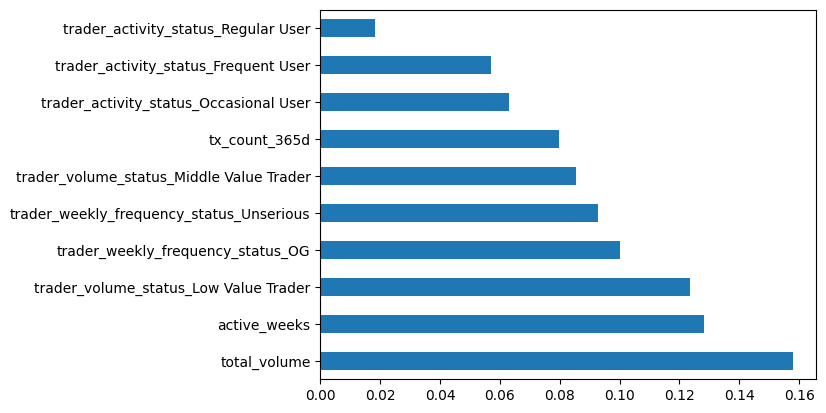

In [16]:
import matplotlib.pyplot as plt

feature_names = numeric_features + list(best_pipeline.named_steps["preprocessor"].named_transformers_["cat"].get_feature_names_out(categorical_features))
importances = best_pipeline.named_steps["classifier"].feature_importances_

pd.Series(importances, index=feature_names).sort_values(ascending=False).head(10).plot(kind="barh")
plt.show()


In [17]:
joblib.dump(best_pipeline, "forest_pipeline_tuned.pkl")
print("Pipeline saved to forest_pipeline_tuned.pkl")


Pipeline saved to forest_pipeline_tuned.pkl
